2 pointer model

In [1]:
import pickle
import bson
import shap
import recursive_feature_elimination

import pandas as pd
import pandas as pd
import numpy as np
import os
import pickle
from bson.objectid import ObjectId
from collections import defaultdict
import timeit
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns

pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
os.chdir("/Users/sakshamarora/Documents/6748 Practicum/project/GT_MSA_LBA")

In [3]:
league = "NCAAM1"
season = "22-23"

In [4]:
merged_df_with_2P = pd.read_pickle(f'data/processed_data/{league}_{season}_2P.pickle')

In [5]:
# Function to clean column names
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

# Select features for the model
X = merged_df_with_2P.drop([
    'game_id', 'team_id', 'team_id', 'season_id', 'player_id', 'shot_id', 'segment_id', 'date', 
    'has_locations', 'has_segments', 'team1', 'team2', 'hometeam', 'Made', 'Time', 'Stat', 'season', 
    'league', 'score','winning_team', 'score_opp', 'And1', 'Blocked', 'Assisted'
], axis=1)

# Clean column names
X = clean_column_names(X)

# Define categorical features
categorical_features = ['Location', 'Zone', 'Period', 'LBA_position', 'year', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X.columns:  # Check if the column exists in the DataFrame
        X[col] = X[col].astype('category')

# Define the target variable
y = merged_df_with_2P['Made']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train.head()

,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Jumpshot,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,Turnaround,Dunk,Step_Back,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
156928,0.39,90.0,1,25.0,5.6,2,418,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,Away,0.444444,0.3,0.400000,0.2,0.666667,0.333333,0.0,0.0,76.0,Mid,So,0.320000,0.387097,50,3,0,2,0.286154,0.189296,0.191351,0.196117,0.196117,0.250000,0,3,1,True,2.0,4.0,0.500000,0.666667,1.666667,0.400000,0.8,0.571429,1.4,0.9,1.8,0.500000,0.900000,1.800000,0.500000,Layup,1.0,3.0,0.333333,0.333333,1.666667,0.200000,0.4,1.4,0.285714,1.1,2.3,0.478261,1.100000,2.300000,0.478261,1.000000,2.000000,0.500000,0.000000,0.000000,NaN,1.0,2.0,5.0,0.400000,0.0,0.0,3.0,0.666667,3.000000,0.222222,0.0,0.0,5.0,1.0,2.8,0.357143,0.0,0.0,10.0,1.4,3.5,0.400000,0.0,0.0,10.0,1.400000,3.500000,0.400000,0.0,0.0,1.0,2.000000,3.000000,0.666667,0.0,0.000000
433537,7.25,106.0,2-2,27.0,12.2,2,291,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,Home,0.800000,0.9,0.800000,0.8,0.666667,0.666667,1.0,1.0,72.0,Small,Sr,0.515152,0.733333,52,-3,0,1,0.196000,0.216854,0.269000,0.253619,0.224654,0.318904,1,2,2,True,2.0,3.0,0.666667,2.333333,3.666667,0.636364,1.4,0.636364,2.2,0.9,2.2,0.409091,0.750000,1.777778,0.421875,Layup,3.0,4.0,0.750000,4.000000,5.333333,0.750000,4.2,6.2,0.677419,3.3,5.3,0.622642,2.583333,4.000000,0.645833,3.315789,5.473684,0.605769,0.578947,1.631579,0.354839,1.0,5.0,9.0,0.555556,0.0,0.0,3.0,5.000000,8.333333,0.600000,0.0,0.0,5.0,5.4,9.0,0.600000,0.0,0.0,10.0,4.4,8.6,0.511628,0.0,0.0,36.0,3.777778,7.305556,0.517110,0.0,0.0,19.0,6.263158,13.368421,0.468504,2.0,0.016807
345745,5.91,59.5,2-2,22.0,10.3,2,34,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,Home,0.500000,0.2,0.400000,0.2,0.000000,0.000000,0.0,0.0,73.0,Small,So,0.421053,0.117647,85,33,0,0,NaN,NaN,NaN,NaN,0.250526,0.600000,1,4,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.000000,0.000000,NaN,Layup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.333333,1.000000,0.333333,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,

In [8]:
X_train.describe()

,Distance,Angle,x_coordinate,y_coordinate,Time_Seconds,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
count,349062.000000,349062.000000,349062.000000,349062.000000,349062.000000,304221.000000,303210.000000,304221.000000,303210.000000,304221.000000,303210.000000,304221.000000,303210.000000,313197.00000,324423.000000,323074.000000,349062.000000,349062.000000,349062.000000,349062.000000,317108.000000,276444.000000,243997.000000,176253.000000,326817.000000,252617.000000,349062.000000,349062.000000,349062.000000,291333.000000,291333.000000,181988.000000,280078.000000,280078.000000,227665.000000,262276.000000,229589.000000,262276.000000,214893.000000,214893.000000,200923.000000,301807.000000,301807.000000,280411.000000,291657.000000,291657.000000,201093.000000,280475.000000,280475.000000,240622.000000,262781.000000,262781.000000,237982.000000,215739.000000,215739.000000,203845.000000,302073.000000,302073.000000,284097.000000,233172.000000,233172.000000,213944.000000,232455.000000,232455.000000,220447.000000,303009.000000,291333.000000,291333.000000,276155.000000,303009.000000,247921.000000,282841.000000,280078.000000,280078.000000,276531.000000,282841.000000,269912.000000,263651.000000,262276.000000,262276.000000,260443.000000,263651.000000,257524.000000,215275.000000,214893.000000,214893.000000,214272.000000,215275.000000,213365.000000,303009.000000,301807.000000,301807.000000,300386.000000,303009.000000,297815.000000,233010.000000,232455.000000,232455.000000,231172.000000,233010.000000,230177.000000
mean,6.642771,94.611308,24.786024,10.024855,600.862480,0.541563,0.541515,0.537110,0.537234,0.534648,0.535040,0.533987,0.534781,77.37364,0.497775,0.496416,33.518080,-0.589998,0.002295,0.253608,0.242362,0.241921,0.242040,0.242646,0.241072,0.228374,0.713933,2.752462,1.008864,1.135453,1.897087,0.565329,1.109395,1.857787,0.539394,1.105361,0.530816,1.850145,1.100439,1.843012,0.522016,1.078344,1.789888,0.524320,1.169058,2.189397,0.519722,1.145822,2.152627,0.511734,1.140046,2.142225,0.511138,1.130061,2.126778,0.509875,1.103469,2.062386,0.513056,0.890746,1.717859,0.496677,0.888131,1.508405,0.503982,0.961466,2.904772,5.618746,0.507904,0.137653,0.049728,2.852691,2.852702,5.538194,0.508528,0.411517,0.050975,4.723210,2.838123,5.511312,0.509607,0.679595,0.051175,9.368352,2.835201,5.505412,0.510399,1.358165,0.051790,15.078328,2.755812,5.323159,0.

In [9]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13915
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763


In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")


Train-------------------------------
Train Accuracy: 0.6187811907340244
Train Precision: 0.5823832219678208
Train Recall: 0.852779345774676
Train F1 Score: 0.6921088860352387
Train AUC ROC: 0.7302487947403291
Test-------------------------------
Test Accuracy: 0.6148671876790502
Test Precision: 0.5798722542452095
Test Recall: 0.8485967672069854
Test F1 Score: 0.6889581964406356
Test AUC ROC: 0.7221953548787626
Optimum Threshold for Maximum F1 Score: 0.35


Text(0.5, 1.0, 'Feature Importance')

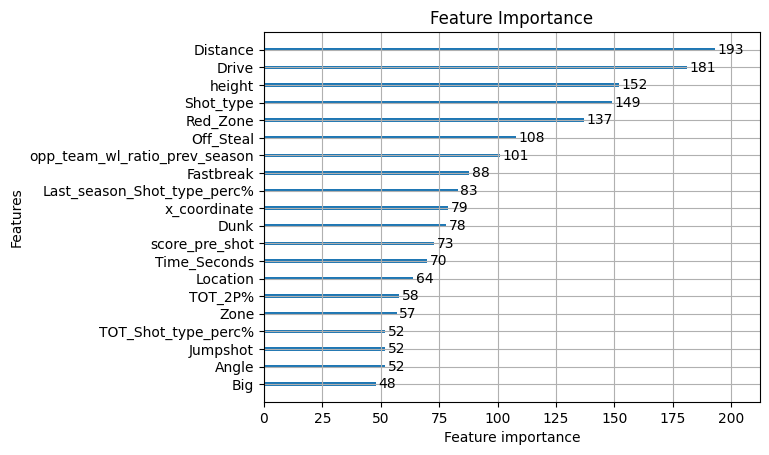

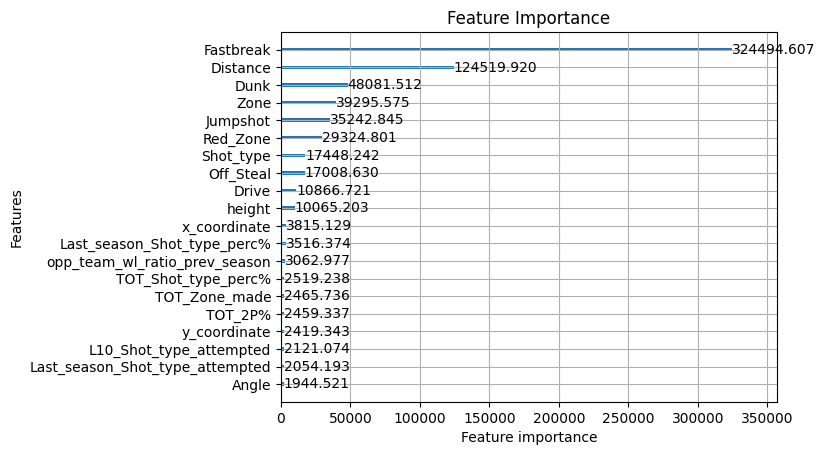

In [11]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [12]:
# Function to plot probabilities
def plot_probabilities(probs, title):
    sns.histplot(probs, kde=True, bins=30)
    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def calculate_combined_probabilities(prob_2p, prob_3p):
    weighted_2p = prob_2p * 2
    weighted_3p = prob_3p * 3
    return np.concatenate([weighted_2p, weighted_3p])

In [13]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [14]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.35


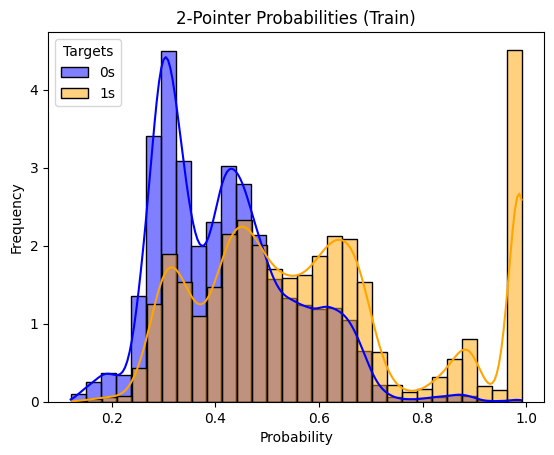

In [15]:
def plot_probabilities_class(probs_0, probs_1, title):
    sns.histplot(probs_0, kde=True, color='blue', bins=30, label='0s', stat='density')
    sns.histplot(probs_1, kde=True, color='orange', bins=30, label='1s', stat='density')

    plt.title(title)
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend(title='Targets')
    plt.show()

y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')
# plot_probabilities_class(y_train_pred_0_3p, y_train_pred_1_3p, '3-Pointer Probabilities (Train)')

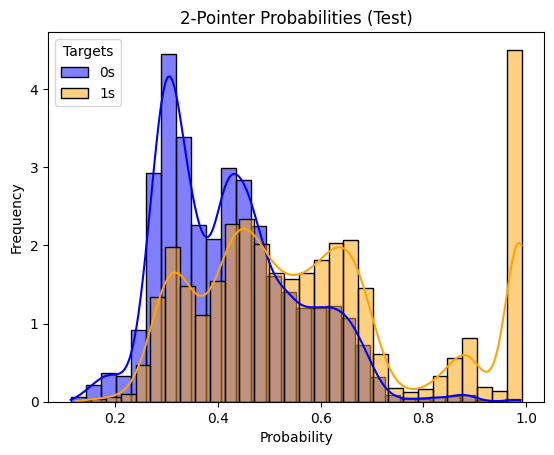

In [16]:
y_test_pred_2p = np.array(y_pred_2p)
# y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
# y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
# y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
# y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
# y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
# plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

# Feature Reduction

In [17]:
rfe_object = recursive_feature_elimination.rfe(X_train,y_train,X_test,y_test,categorical_features)

[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13915
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 124
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763
[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13436
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 109
[LightGBM]

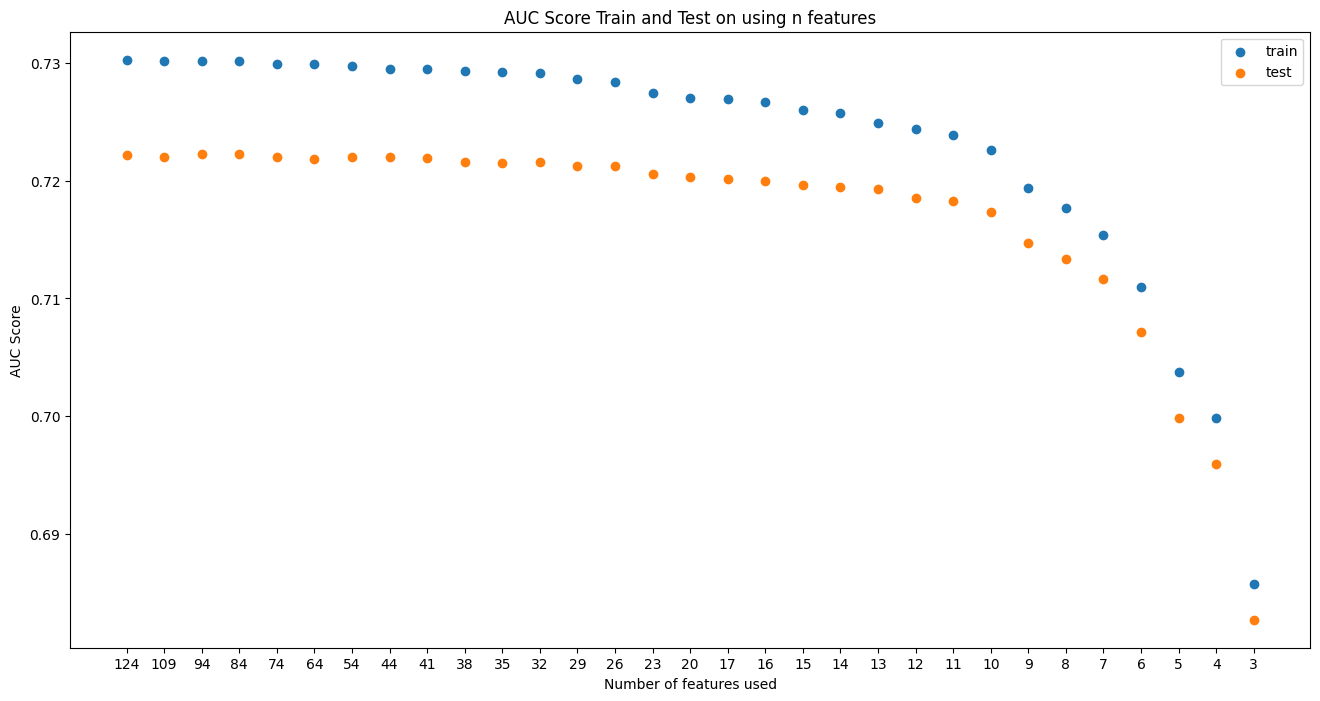

In [18]:
df,fig = rfe_object.run_rfe()

In [19]:
SELECT_TOP_K_FEATURES = 26
rfe_object.get_top_k_feature_list(SELECT_TOP_K_FEATURES)

array(['Fastbreak', 'Distance', 'Dunk', 'Jumpshot', 'Red_Zone',
       'Off_Steal', 'Shot_type', 'height', 'Drive', 'Zone',
       'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'TOT_Zone_made', 'Layup', 'TOT_Shot_type_perc%', 'TOT_2P%',
       'L10_Shot_type_attempted', 'x_coordinate',
       'Last_season_Shot_type_attempted', 'score_pre_shot', 'Location',
       'Last_season_Zone_made', 'Angle', 'Big', 'TOT_Shot_type_made',
       'team_wl_ratio_prev_season'], dtype=object)

### Reduced features

In [20]:
Two_features_reduced = ['Fastbreak', 'Distance', 'Dunk', 'Jumpshot', 'Red_Zone',
       'Off_Steal', 'Shot_type', 'height', 'Drive', 'Zone',
       'opp_team_wl_ratio_prev_season', 'Last_season_Shot_type_perc%',
       'TOT_Zone_made', 'TOT_Shot_type_perc%', 'Layup', 'TOT_2P%',
       'Last_season_Shot_type_attempted', 'L10_Shot_type_attempted',
       'score_pre_shot', 'Angle', 'x_coordinate', 'Last_season_Zone_made',
       'Location', 'Big', 'TOT_Shot_type_made', 'Time_Seconds']


In [21]:
len(Two_features_reduced)

26

In [22]:
print(X[Two_features_reduced].dtypes)

Fastbreak                              bool
Distance                            float64
Dunk                                   bool
Jumpshot                               bool
Red_Zone                               bool
Off_Steal                              bool
Shot_type                          category
height                              float64
Drive                                  bool
Zone                               category
opp_team_wl_ratio_prev_season       float64
Last_season_Shot_type_perc%         float64
TOT_Zone_made                       float64
TOT_Shot_type_perc%                 float64
Layup                                  bool
TOT_2P%                             float64
Last_season_Shot_type_attempted     float64
L10_Shot_type_attempted             float64
score_pre_shot                        int64
Angle                               float64
x_coordinate                        float64
Last_season_Zone_made               float64
Location                        

In [23]:
X_subset = X[Two_features_reduced]

Correlation check

In [24]:
numeric_cols = X_subset.select_dtypes(include=['bool', 'float64', 'int64']).columns
X_subset_numeric = X_subset[numeric_cols]

def remove_highly_correlated_features(df, threshold):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    while True:
        to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
        if not to_drop:
            break

        feature_to_drop = to_drop[0]
        df = df.drop(columns=[feature_to_drop])
        print(f"Dropping feature: {feature_to_drop}")

        corr_matrix = df.corr().abs()
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    return df

threshold = 0.7
X_reduced = remove_highly_correlated_features(X_subset_numeric, threshold)


Dropping feature: L10_Shot_type_attempted
Dropping feature: Last_season_Zone_made


In [25]:
categorical_cols = X_subset.select_dtypes(include=['category']).columns
X_final = pd.concat([X_reduced, X_subset[categorical_cols]], axis=1)

In [26]:
print(X_subset.shape)
print(X_final.shape)

(436328, 26)
(436328, 24)


Final model

In [27]:
categorical_features = ['Location', 'Zone', 'Shot_type'] 

# Convert categorical columns to 'category' type
for col in categorical_features:
    if col in X_final.columns:  # Check if the column exists in the DataFrame
        X_final[col] = X_final[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [28]:
# Create a LightGBM dataset and specify the categorical features
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categorical_features)

# Set up LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2759
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763


In [29]:
def find_best_threshold(y_true, y_pred_probs):
    thresholds = [i/100 for i in range(100)]  # This gives [0, 0.01, 0.02,...,0.99]
    best_threshold = 0
    best_f1 = 0
    
    for threshold in thresholds:
        y_pred_binary = [1 if x >= threshold else 0 for x in y_pred_probs]
        current_f1 = f1_score(y_true, y_pred_binary)
        
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            
    return best_threshold

# Find the best threshold on the training data
y_train_pred = bst.predict(X_train, num_iteration=bst.best_iteration)
best_threshold = find_best_threshold(y_test, y_pred)

# Now, apply the best threshold to get binary predictions
y_train_pred_binary = [1 if x >= best_threshold else 0 for x in y_train_pred]
y_pred_binary = [1 if x >= best_threshold else 0 for x in y_pred]

# Performance Metrics for Train data
train_accuracy = accuracy_score(y_train, y_train_pred_binary)
train_precision = precision_score(y_train, y_train_pred_binary)
train_recall = recall_score(y_train, y_train_pred_binary)
train_f1 = f1_score(y_train, y_train_pred_binary)
train_auc_roc = roc_auc_score(y_train, y_train_pred)

print('Train-------------------------------')
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train F1 Score: {train_f1}")
print(f"Train AUC ROC: {train_auc_roc}")

# Performance Metrics for Test data
test_accuracy = accuracy_score(y_test, y_pred_binary)
test_precision = precision_score(y_test, y_pred_binary)
test_recall = recall_score(y_test, y_pred_binary)
test_f1 = f1_score(y_test, y_pred_binary)
test_auc_roc = roc_auc_score(y_test, y_pred)

print('Test-------------------------------')
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")
print(f"Test AUC ROC: {test_auc_roc}")

# Displaying the best threshold
print(f"Optimum Threshold for Maximum F1 Score: {best_threshold}")

Train-------------------------------
Train Accuracy: 0.6129713346053137
Train Precision: 0.5768752242178138
Train Recall: 0.8618509205567244
Train F1 Score: 0.691139790354477
Train AUC ROC: 0.7281612729158543
Test-------------------------------
Test Accuracy: 0.6094698966378659
Test Precision: 0.5747832867036646
Test Recall: 0.8571233157786745
Test F1 Score: 0.6881177245772018
Test AUC ROC: 0.7209844565658747
Optimum Threshold for Maximum F1 Score: 0.34


Text(0.5, 1.0, 'Feature Importance')

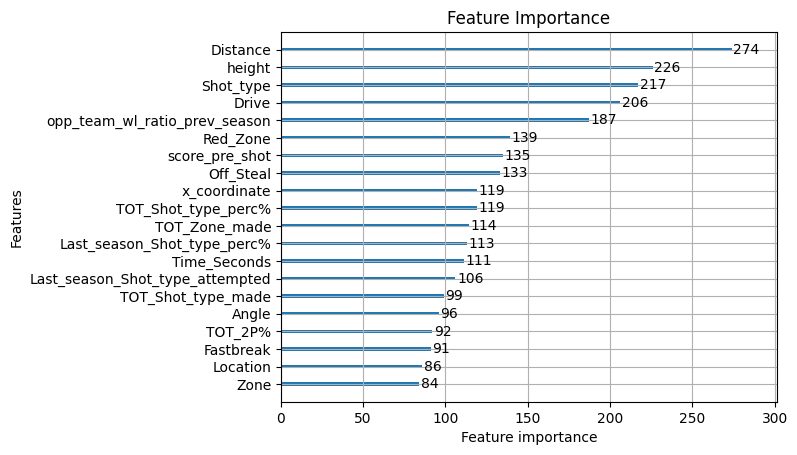

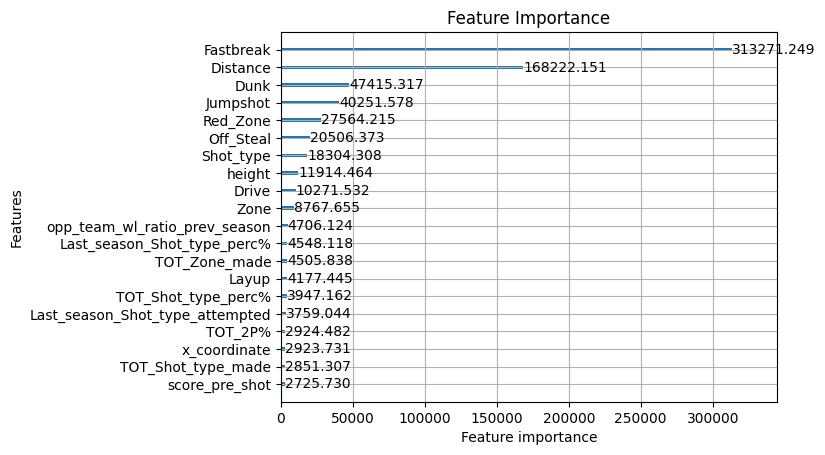

In [30]:
lgb.plot_importance(bst, importance_type='split', max_num_features=20)
plt.title("Feature Importance")
lgb.plot_importance(bst, importance_type='gain', max_num_features=20)
plt.title("Feature Importance")

In [31]:
y_train_pred_2p = y_train_pred
best_threshold_2p = best_threshold
y_pred_2p = y_pred
y_train_2p = y_train
y_test_2p = y_test
X_2p = X

In [32]:
X_2p.shape

(436328, 124)

In [33]:
# Displaying the best thresholds
print(f"Best threshold for 2-pointers: {best_threshold_2p}")
# print(f"Best threshold for 3-pointers: {best_threshold_3p}")

# Apply the best threshold to get binary predictions
y_train_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_train_pred_2p]
# y_train_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_train_pred_3p]
y_pred_2p_binary = [1 if x >= best_threshold_2p else 0 for x in y_pred_2p]
# y_pred_3p_binary = [1 if x >= best_threshold_3p else 0 for x in y_pred_3p]

Best threshold for 2-pointers: 0.34


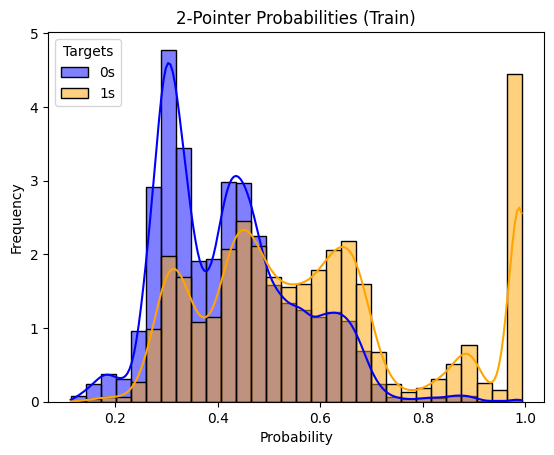

In [34]:
y_train_pred_0_2p = y_train_pred_2p[y_train_2p == 0]
y_train_pred_1_2p = y_train_pred_2p[y_train_2p == 1]

# y_train_pred_0_3p = y_train_pred_3p[y_train_3p == 0]
# y_train_pred_1_3p = y_train_pred_3p[y_train_3p == 1]

plot_probabilities_class(y_train_pred_0_2p, y_train_pred_1_2p, '2-Pointer Probabilities (Train)')

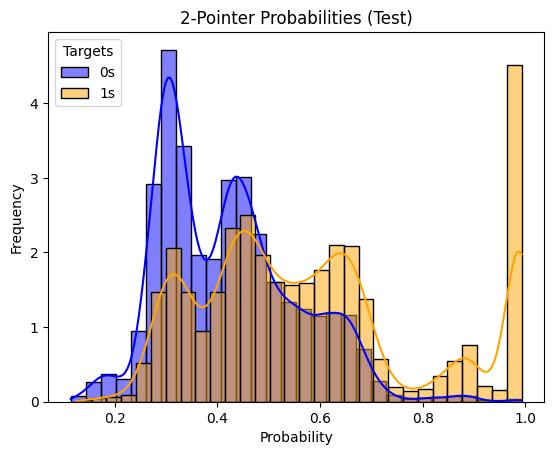

In [35]:
y_test_pred_2p = np.array(y_pred_2p)
# y_test_pred_3p = np.array(y_pred_3p)
y_test_2p = np.array(y_test_2p)
# y_test_3p = np.array(y_test_3p)

y_test_2p = y_test_2p.reshape(-1)
# y_test_3p = y_test_3p.reshape(-1)

y_test_pred_0_2p = y_test_pred_2p[y_test_2p == 0]
y_test_pred_1_2p = y_test_pred_2p[y_test_2p == 1]
# y_test_pred_0_3p = y_test_pred_3p[y_test_3p == 0]
# y_test_pred_1_3p = y_test_pred_3p[y_test_3p == 1]

plot_probabilities_class(y_test_pred_0_2p, y_test_pred_1_2p, '2-Pointer Probabilities (Test)')
# plot_probabilities_class(y_test_pred_0_3p, y_test_pred_1_3p, '3-Pointer Probabilities (Test)')

## SHAP for Explainability and Sanity Check

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


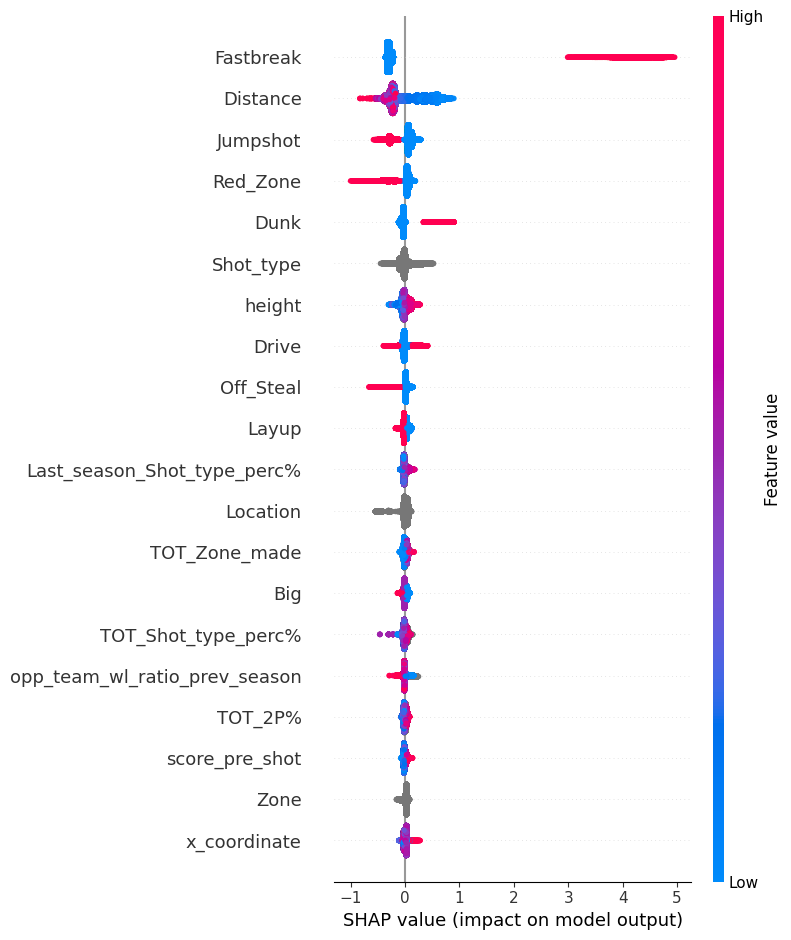

In [36]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[1], X_train, plot_type='dot')

In [37]:
#saving model object
bst.save_model(f'Inference/2p_{league}_{season}_model.txt')

Final Partial Dependence Plots for Features with no missing data

[LightGBM] [Info] Number of positive: 175383, number of negative: 173679
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2759
[LightGBM] [Info] Number of data points in the train set: 349062, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502441 -> initscore=0.009763
[LightGBM] [Info] Start training from score 0.009763


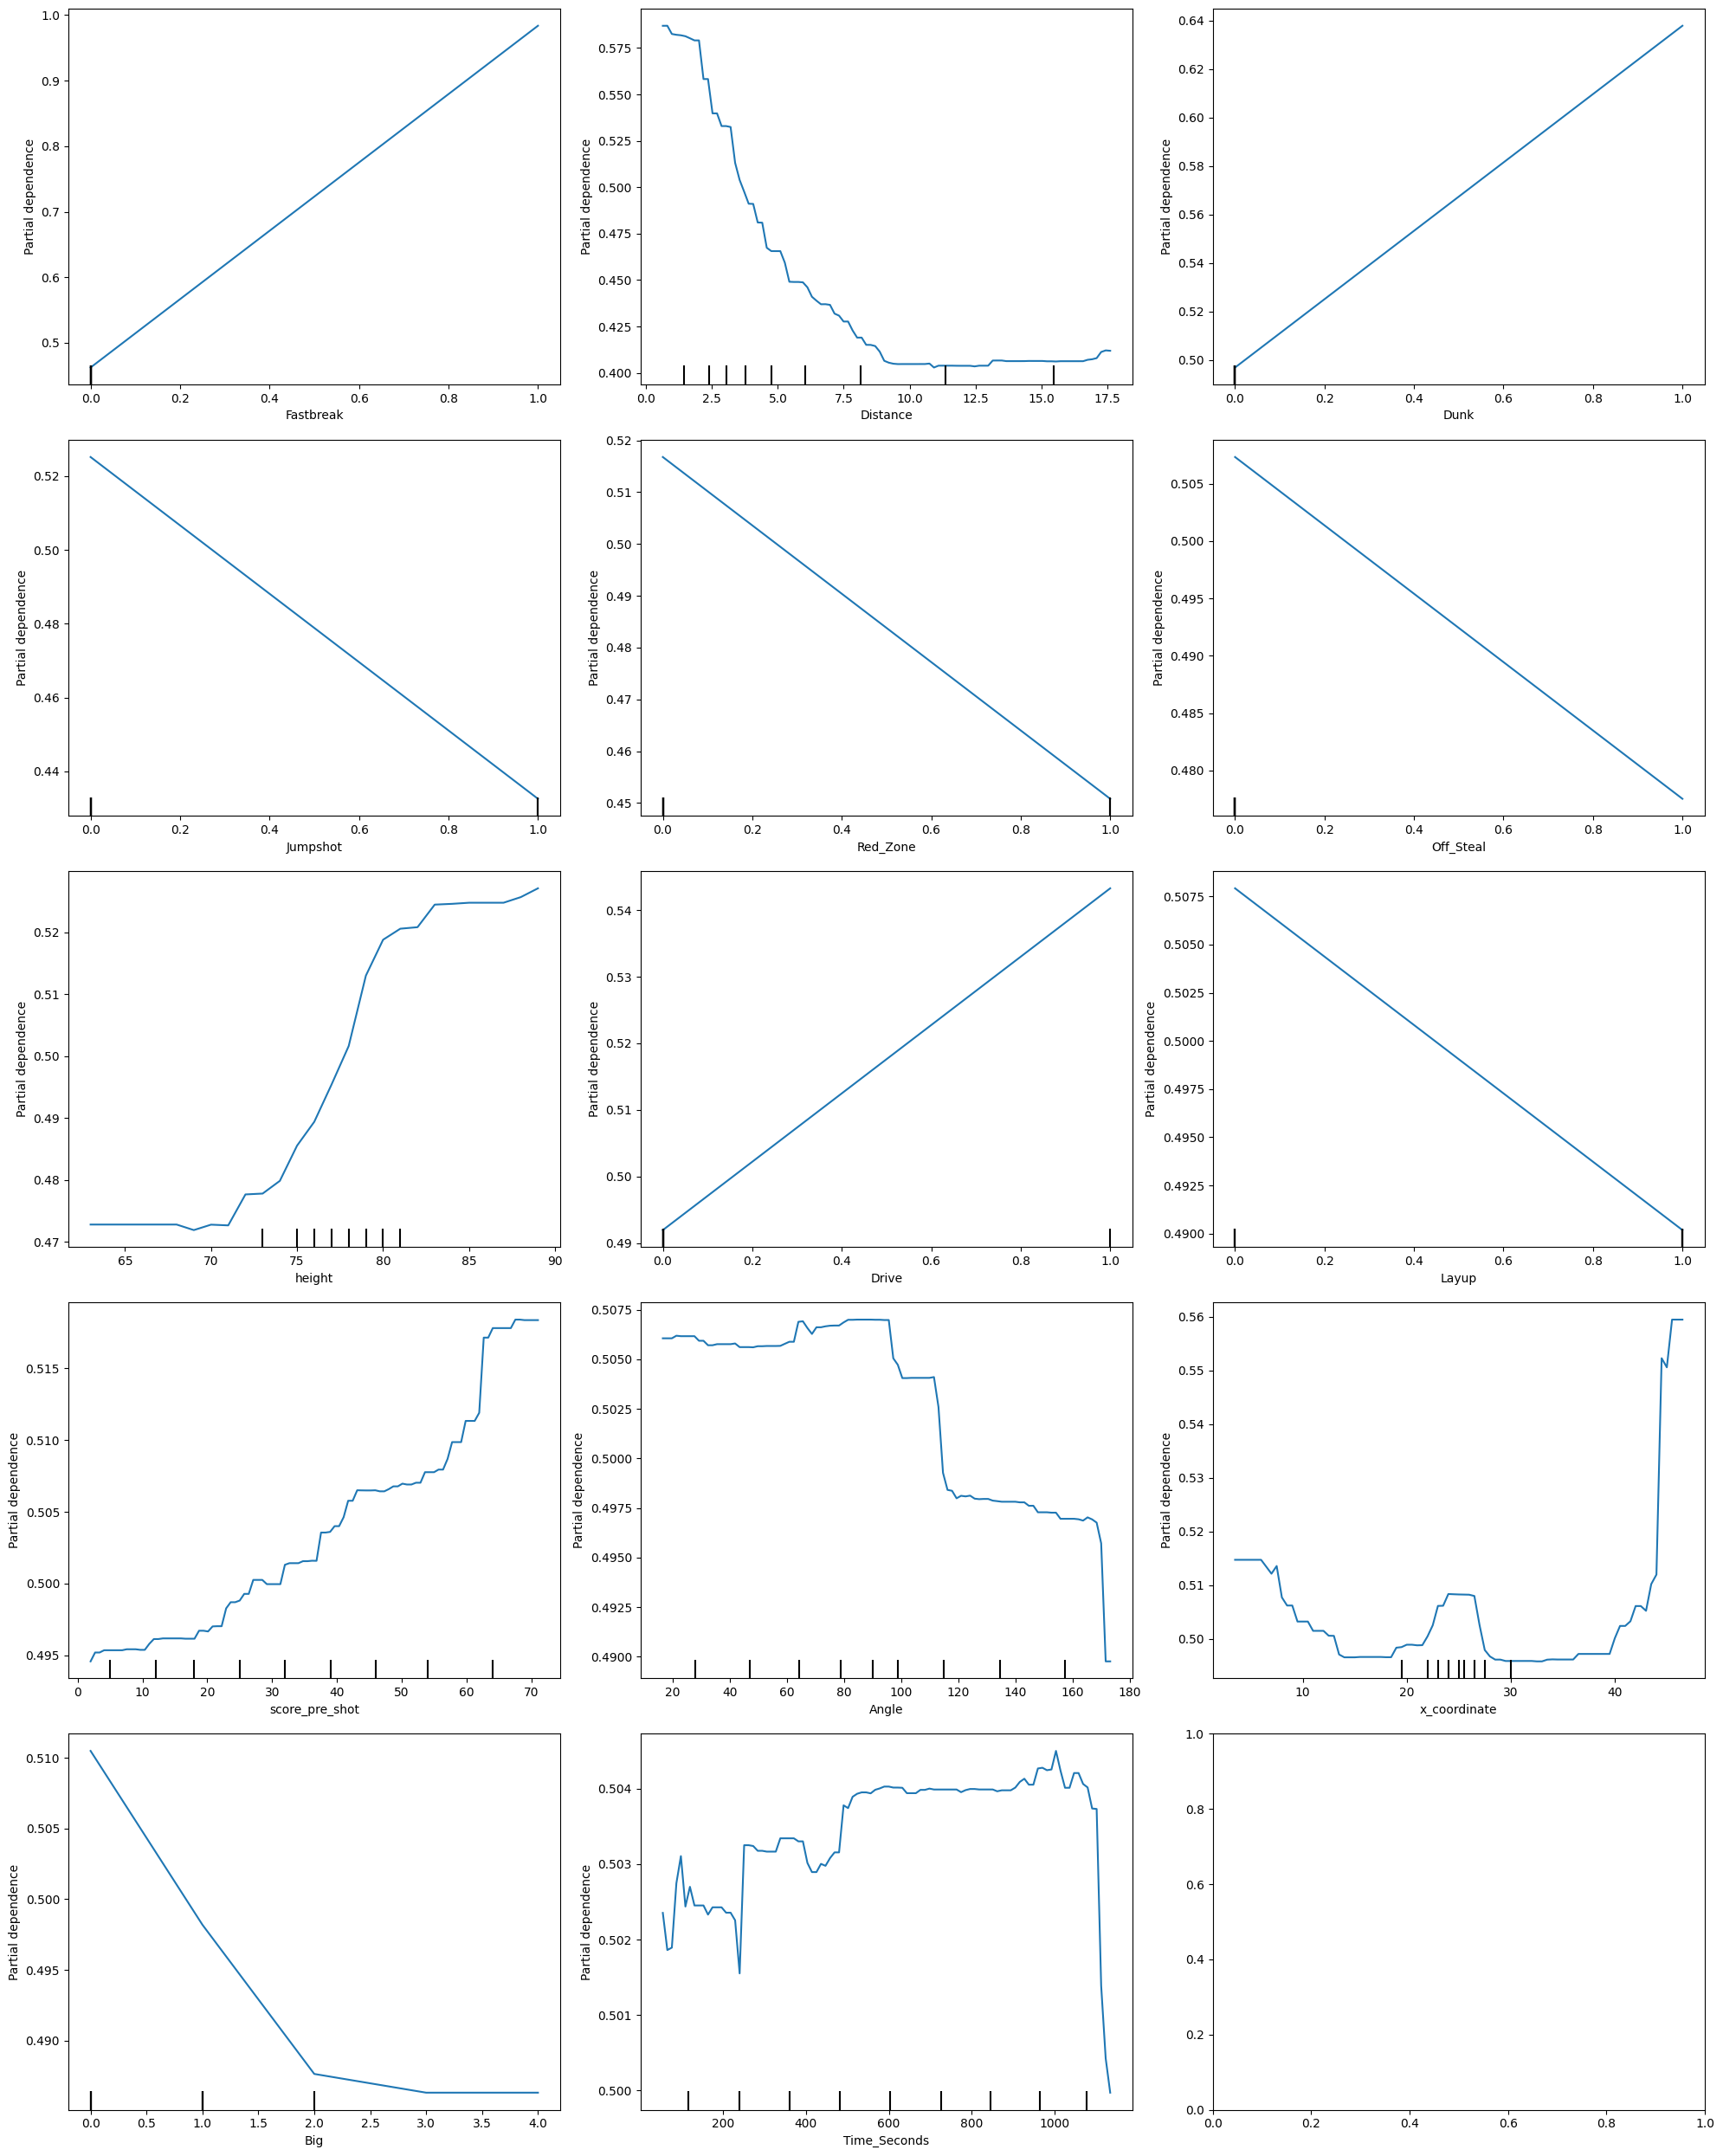

In [38]:
from lightgbm import LGBMClassifier
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Train the model
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Define features to plot
features_to_plot = ['Fastbreak', 'Distance', 'Dunk', 'Jumpshot', 'Red_Zone',
                    'Off_Steal', 'height', 'Drive',  'Layup',
                    'score_pre_shot', 'Angle', 'x_coordinate', 'Big', 'Time_Seconds']

# Set up a grid layout and size for the plots
n_cols = 3  # Number of columns in the grid
n_rows = (len(features_to_plot) + n_cols - 1) // n_cols  # Calculate the number of rows needed

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))  # Adjust the figsize as needed
axs = axs.flatten()[:len(features_to_plot)]  # Flatten and trim excess axes

# Create partial dependence plots
for i, feature in enumerate(features_to_plot):
    PartialDependenceDisplay.from_estimator(
        lgbm_model, X_train, [feature], ax=axs[i]
    )
    axs[i].set_xlabel(feature)  # Set x-axis label

plt.tight_layout()
plt.show()